# Big Data Analytics of Hotel Bookings

### Data Import

In [2]:
# import modules
import pandas as pd
from pyspark.sql import SparkSession

In [3]:
# build spark session and spark context
spark = SparkSession.builder \
        .appName("hotel") \
        .getOrCreate()
sc = spark.sparkContext

In [4]:
df = spark.read.csv('hotel_bookings.csv',  inferSchema=True, header = True)
df.take(2)

[Row(hotel='Resort Hotel', is_canceled=0, lead_time=342, arrival_date_year=2015, arrival_date_month='July', arrival_date_week_number=27, arrival_date_day_of_month=1, stays_in_weekend_nights=0, stays_in_week_nights=0, adults=2, children='0', babies=0, meal='BB', country='PRT', market_segment='Direct', distribution_channel='Direct', is_repeated_guest=0, previous_cancellations=0, previous_bookings_not_canceled=0, reserved_room_type='C', assigned_room_type='C', booking_changes=3, deposit_type='No Deposit', agent='NULL', company='NULL', days_in_waiting_list=0, customer_type='Transient', adr=0.0, required_car_parking_spaces=0, total_of_special_requests=0, reservation_status='Check-Out', reservation_status_date='2015-07-01'),
 Row(hotel='Resort Hotel', is_canceled=0, lead_time=737, arrival_date_year=2015, arrival_date_month='July', arrival_date_week_number=27, arrival_date_day_of_month=1, stays_in_weekend_nights=0, stays_in_week_nights=0, adults=2, children='0', babies=0, meal='BB', country='

In [5]:
# view columns and schema
df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

### Data Preprocessing

In [6]:
# replace the strings "NULL" and "NA" with null value
df_withNull = df.replace('NULL', None).replace('NA', None)

# view number of null values per column
from pyspark.sql.functions import isnan, when, count, col
df_withNull.select([count(when(col(c).isNull(), c)).alias(c) for c in df_withNull.columns]).show()

+-----+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+---+---------------------------+-------------------------+------------------+-----------------------+
|hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|adr|required_car_parking_spaces|total_of_special_reque

In [7]:
# replace null values in 'children' to 0 since there are only 4
df2 = df_withNull.fillna({'children':0})

# replace 'children' datatype to int
df2 = df2.withColumn('children', col('children').cast("Int"))

In [8]:
# drop 'company' and 'agent' due to high null count
df2 = df2.drop('agent', 'company','country', 'arrival_date_week_number')

In [9]:
df2.dtypes

[('hotel', 'string'),
 ('is_canceled', 'int'),
 ('lead_time', 'int'),
 ('arrival_date_year', 'int'),
 ('arrival_date_month', 'string'),
 ('arrival_date_day_of_month', 'int'),
 ('stays_in_weekend_nights', 'int'),
 ('stays_in_week_nights', 'int'),
 ('adults', 'int'),
 ('children', 'int'),
 ('babies', 'int'),
 ('meal', 'string'),
 ('market_segment', 'string'),
 ('distribution_channel', 'string'),
 ('is_repeated_guest', 'int'),
 ('previous_cancellations', 'int'),
 ('previous_bookings_not_canceled', 'int'),
 ('reserved_room_type', 'string'),
 ('assigned_room_type', 'string'),
 ('booking_changes', 'int'),
 ('deposit_type', 'string'),
 ('days_in_waiting_list', 'int'),
 ('customer_type', 'string'),
 ('adr', 'double'),
 ('required_car_parking_spaces', 'int'),
 ('total_of_special_requests', 'int'),
 ('reservation_status', 'string'),
 ('reservation_status_date', 'string')]

In [10]:
df2.groupBy('arrival_date_month').count().show()

+------------------+-----+
|arrival_date_month|count|
+------------------+-----+
|              July|12661|
|          November| 6794|
|          February| 8068|
|           January| 5929|
|             March| 9794|
|           October|11160|
|               May|11791|
|            August|13877|
|             April|11089|
|              June|10939|
|          December| 6780|
|         September|10508|
+------------------+-----+



In [11]:
#month_num = df2.replace('January', '1')\
#                .replace('February', '2')\
#                .replace('March', '3')\
#                .replace('April', '4')\
#                .replace('May', '5')\
#                .replace('June', '6')



In [12]:
#month_num = month_num.replace('July', '7')\
#                      .replace('August', '8')\
#                .replace('September', '9')\
#                .replace('October', '10')\
#                .replace('November', '11')\
#                .replace('December', '12')



**Data Preprocessing Todo's**
- map arrival_date_month from strings to numbers: so "January" = 1, etc.
- numerically encode all the other string variables, otherwise remove them  

In [13]:
# numerically encode arrival_date_month
#done in next cell?

Ellipsis

In [15]:
#numerically encode all columns of type string

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, OneHotEncoderModel, StringIndexer


col_string=['hotel', 'arrival_date_month','meal','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type','reservation_status','reservation_status_date']
col_num=[x+"_NUMERIC" for x in col_string]

#add other columns for encoding
col_num=col_num+['arrival_date_year','arrival_date_day_of_month']

col_oh=[x+"_oh" for x in col_string]

col_oh=col_oh+['arrival_date_year_oh','arrival_date_day_of_month_oh']

In [16]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_NUMERIC").fit(df2) for column in col_string]
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df2).transform(df2)

In [17]:
df_indexed.dtypes

[('hotel', 'string'),
 ('is_canceled', 'int'),
 ('lead_time', 'int'),
 ('arrival_date_year', 'int'),
 ('arrival_date_month', 'string'),
 ('arrival_date_day_of_month', 'int'),
 ('stays_in_weekend_nights', 'int'),
 ('stays_in_week_nights', 'int'),
 ('adults', 'int'),
 ('children', 'int'),
 ('babies', 'int'),
 ('meal', 'string'),
 ('market_segment', 'string'),
 ('distribution_channel', 'string'),
 ('is_repeated_guest', 'int'),
 ('previous_cancellations', 'int'),
 ('previous_bookings_not_canceled', 'int'),
 ('reserved_room_type', 'string'),
 ('assigned_room_type', 'string'),
 ('booking_changes', 'int'),
 ('deposit_type', 'string'),
 ('days_in_waiting_list', 'int'),
 ('customer_type', 'string'),
 ('adr', 'double'),
 ('required_car_parking_spaces', 'int'),
 ('total_of_special_requests', 'int'),
 ('reservation_status', 'string'),
 ('reservation_status_date', 'string'),
 ('hotel_NUMERIC', 'double'),
 ('arrival_date_month_NUMERIC', 'double'),
 ('meal_NUMERIC', 'double'),
 ('market_segment_NUMER

In [18]:
#one-hot encode all columns in col_num

ohe = OneHotEncoder(dropLast=False)
ohe.setInputCols(col_num)
ohe.setOutputCols(col_oh)
model = ohe.fit(df_indexed)

df_casted=model.transform(df_indexed)


In [19]:
df_casted.dtypes

[('hotel', 'string'),
 ('is_canceled', 'int'),
 ('lead_time', 'int'),
 ('arrival_date_year', 'int'),
 ('arrival_date_month', 'string'),
 ('arrival_date_day_of_month', 'int'),
 ('stays_in_weekend_nights', 'int'),
 ('stays_in_week_nights', 'int'),
 ('adults', 'int'),
 ('children', 'int'),
 ('babies', 'int'),
 ('meal', 'string'),
 ('market_segment', 'string'),
 ('distribution_channel', 'string'),
 ('is_repeated_guest', 'int'),
 ('previous_cancellations', 'int'),
 ('previous_bookings_not_canceled', 'int'),
 ('reserved_room_type', 'string'),
 ('assigned_room_type', 'string'),
 ('booking_changes', 'int'),
 ('deposit_type', 'string'),
 ('days_in_waiting_list', 'int'),
 ('customer_type', 'string'),
 ('adr', 'double'),
 ('required_car_parking_spaces', 'int'),
 ('total_of_special_requests', 'int'),
 ('reservation_status', 'string'),
 ('reservation_status_date', 'string'),
 ('hotel_NUMERIC', 'double'),
 ('arrival_date_month_NUMERIC', 'double'),
 ('meal_NUMERIC', 'double'),
 ('market_segment_NUMER

In [20]:
#check oh encoded df_casted
df_casted.groupBy('booking_changes').count().show()

+---------------+------+
|booking_changes| count|
+---------------+------+
|             12|     2|
|              1| 12701|
|             13|     5|
|              6|    63|
|             16|     2|
|              3|   927|
|             20|     1|
|              5|   118|
|             15|     3|
|             17|     2|
|              9|     8|
|              4|   376|
|              8|    17|
|              7|    31|
|             10|     6|
|             21|     1|
|             11|     2|
|             14|     5|
|              2|  3805|
|              0|101314|
+---------------+------+
only showing top 20 rows



In [21]:
df_casted.groupBy('arrival_date_year_oh').count().show()

+--------------------+-----+
|arrival_date_year_oh|count|
+--------------------+-----+
| (2018,[2017],[1.0])|40687|
| (2018,[2015],[1.0])|21996|
| (2018,[2016],[1.0])|56707|
+--------------------+-----+



In [22]:
df_encoded=df_casted.drop(*col_string)
df_encoded=df_encoded.drop(*col_num)

In [23]:
df_encoded.dtypes

[('is_canceled', 'int'),
 ('lead_time', 'int'),
 ('stays_in_weekend_nights', 'int'),
 ('stays_in_week_nights', 'int'),
 ('adults', 'int'),
 ('children', 'int'),
 ('babies', 'int'),
 ('is_repeated_guest', 'int'),
 ('previous_cancellations', 'int'),
 ('previous_bookings_not_canceled', 'int'),
 ('booking_changes', 'int'),
 ('days_in_waiting_list', 'int'),
 ('adr', 'double'),
 ('required_car_parking_spaces', 'int'),
 ('total_of_special_requests', 'int'),
 ('distribution_channel_oh', 'vector'),
 ('customer_type_oh', 'vector'),
 ('reservation_status_date_oh', 'vector'),
 ('arrival_date_day_of_month_oh', 'vector'),
 ('reservation_status_oh', 'vector'),
 ('market_segment_oh', 'vector'),
 ('reserved_room_type_oh', 'vector'),
 ('assigned_room_type_oh', 'vector'),
 ('meal_oh', 'vector'),
 ('hotel_oh', 'vector'),
 ('deposit_type_oh', 'vector'),
 ('arrival_date_year_oh', 'vector'),
 ('arrival_date_month_oh', 'vector')]

In [24]:
df_encoded.groupBy('arrival_date_month_oh').count().show()

+---------------------+-----+
|arrival_date_month_oh|count|
+---------------------+-----+
|       (12,[0],[1.0])|13877|
|       (12,[9],[1.0])| 6794|
|       (12,[8],[1.0])| 8068|
|      (12,[10],[1.0])| 6780|
|       (12,[1],[1.0])|12661|
|       (12,[4],[1.0])|11089|
|       (12,[3],[1.0])|11160|
|       (12,[6],[1.0])|10508|
|       (12,[5],[1.0])|10939|
|       (12,[2],[1.0])|11791|
|       (12,[7],[1.0])| 9794|
|      (12,[11],[1.0])| 5929|
+---------------------+-----+



In [25]:
df_encoded.show(2)

+-----------+---------+-----------------------+--------------------+------+--------+------+-----------------+----------------------+------------------------------+---------------+--------------------+---+---------------------------+-------------------------+-----------------------+----------------+--------------------------+----------------------------+---------------------+-----------------+---------------------+---------------------+-------------+-------------+---------------+--------------------+---------------------+
|is_canceled|lead_time|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|booking_changes|days_in_waiting_list|adr|required_car_parking_spaces|total_of_special_requests|distribution_channel_oh|customer_type_oh|reservation_status_date_oh|arrival_date_day_of_month_oh|reservation_status_oh|market_segment_oh|reserved_room_type_oh|assigned_room_type_oh|      meal_oh|     hotel_oh|deposi

In [26]:
columns_ = df_encoded.columns
columns_

['is_canceled',
 'lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'distribution_channel_oh',
 'customer_type_oh',
 'reservation_status_date_oh',
 'arrival_date_day_of_month_oh',
 'reservation_status_oh',
 'market_segment_oh',
 'reserved_room_type_oh',
 'assigned_room_type_oh',
 'meal_oh',
 'hotel_oh',
 'deposit_type_oh',
 'arrival_date_year_oh',
 'arrival_date_month_oh']

In [27]:
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors

df_encoded=df_casted.drop(*col_string)
df_encoded=df_encoded.drop(*col_num)

#columns of all vector type data that are going to be normalied 
columns_ = ['distribution_channel_oh',
 'customer_type_oh',
 'reservation_status_date_oh',
 'arrival_date_day_of_month_oh',
 'reservation_status_oh',
 'market_segment_oh',
 'reserved_room_type_oh',
 'assigned_room_type_oh',
 'meal_oh',
 'hotel_oh',
 'deposit_type_oh',
 'arrival_date_year_oh',
 'arrival_date_month_oh']


#normalizing all vector type data with l^1 norm
for column in columns_:
    normalizer = Normalizer(inputCol=column, outputCol=column+"_NORM", p=1.0) 
    l1NormData = normalizer.transform(df_encoded)
    df_encoded = l1NormData
l1NormData = df_encoded
print("Normalized using L^1 norm")

l1NormData = l1NormData.drop(*columns_)
#l1NormData.show()

Normalized using L^1 norm


In [28]:
l1NormData.dtypes

[('is_canceled', 'int'),
 ('lead_time', 'int'),
 ('stays_in_weekend_nights', 'int'),
 ('stays_in_week_nights', 'int'),
 ('adults', 'int'),
 ('children', 'int'),
 ('babies', 'int'),
 ('is_repeated_guest', 'int'),
 ('previous_cancellations', 'int'),
 ('previous_bookings_not_canceled', 'int'),
 ('booking_changes', 'int'),
 ('days_in_waiting_list', 'int'),
 ('adr', 'double'),
 ('required_car_parking_spaces', 'int'),
 ('total_of_special_requests', 'int'),
 ('distribution_channel_oh_NORM', 'vector'),
 ('customer_type_oh_NORM', 'vector'),
 ('reservation_status_date_oh_NORM', 'vector'),
 ('arrival_date_day_of_month_oh_NORM', 'vector'),
 ('reservation_status_oh_NORM', 'vector'),
 ('market_segment_oh_NORM', 'vector'),
 ('reserved_room_type_oh_NORM', 'vector'),
 ('assigned_room_type_oh_NORM', 'vector'),
 ('meal_oh_NORM', 'vector'),
 ('hotel_oh_NORM', 'vector'),
 ('deposit_type_oh_NORM', 'vector'),
 ('arrival_date_year_oh_NORM', 'vector'),
 ('arrival_date_month_oh_NORM', 'vector')]

In [39]:
# convert to RDD
# data_rdd = df2.rdd

data_rdd = df_encoded.rdd

seed = 42

# 70/30 test train split
train, test = data_rdd.randomSplit([0.7, 0.3], seed)

### Exploratory Data Analysis

In [81]:
import matplotlib.pyplot as plt 
from pyspark.sql.functions import *
import pyspark.sql.functions as f

In [73]:
df2.describe(['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies']).show()

+-------+-----------------------+--------------------+------------------+-------------------+--------------------+
|summary|stays_in_weekend_nights|stays_in_week_nights|            adults|           children|              babies|
+-------+-----------------------+--------------------+------------------+-------------------+--------------------+
|  count|                 119390|              119390|            119390|             119390|              119390|
|   mean|     0.9275986263506156|   2.500301532791691|1.8564033838679956|0.10388642264846303|0.007948739425412514|
| stddev|     0.9986134945978816|  1.9082856150479093|0.5792609988327523| 0.3985552216824472| 0.09743619130126377|
|    min|                      0|                   0|                 0|                  0|                   0|
|    max|                     19|                  50|                55|                 10|                  10|
+-------+-----------------------+--------------------+------------------+-------

In [75]:
df2.groupBy('arrival_date_month','hotel').sum('is_canceled').sort('arrival_date_month','hotel').show()

+------------------+------------+----------------+
|arrival_date_month|       hotel|sum(is_canceled)|
+------------------+------------+----------------+
|             April|  City Hotel|            3465|
|             April|Resort Hotel|            1059|
|            August|  City Hotel|            3602|
|            August|Resort Hotel|            1637|
|          December|  City Hotel|            1740|
|          December|Resort Hotel|             631|
|          February|  City Hotel|            1901|
|          February|Resort Hotel|             795|
|           January|  City Hotel|            1482|
|           January|Resort Hotel|             325|
|              July|  City Hotel|            3306|
|              July|Resort Hotel|            1436|
|              June|  City Hotel|            3528|
|              June|Resort Hotel|            1007|
|             March|  City Hotel|            2386|
|             March|Resort Hotel|             763|
|               May|  City Hote

In [68]:
#count of cancellation by hotel
df2.groupBy('hotel').count().select('hotel', f.col('count')).show()

+------------+-----+
|       hotel|count|
+------------+-----+
|  City Hotel|79330|
|Resort Hotel|40060|
+------------+-----+



In [77]:
#cancellations by hotel type
df2.groupBy('hotel', 'is_canceled').count().show()

+------------+-----------+-----+
|       hotel|is_canceled|count|
+------------+-----------+-----+
|Resort Hotel|          0|28938|
|  City Hotel|          0|46228|
|Resort Hotel|          1|11122|
|  City Hotel|          1|33102|
+------------+-----------+-----+



ValueError: setting an array element with a sequence.

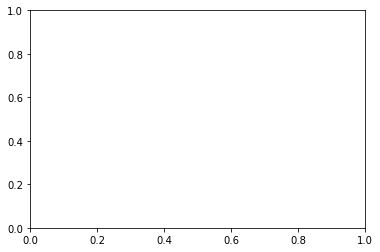

In [92]:
#to visualize, we use matplotlib

y_iscancel = [val.iscancel for val in df2.select('is_canceled').groupBy('is_canceled').count()]
x_hoteltype = [val.hotel for val in df2.select('hotel').groupBy('hotel').count()]

plt.plot(x_hoteltype, y_iscancel)

plt.ylabel('Count')
plt.xlabel('Hotel Type')
plt.title('Hotel Cancellations by Hotel Type')
plt.legend(['Is canceled'], loc='upper left')

plt.show()

In [76]:
# for 'meal': undefined/SC are same, they mean no meal package. BB is bed&breakfast, HB is breakfast and dinner, and FB is full breakfast lunch and dinner

# replace Undefined with SC in meal package
df2 = df2.replace('Undefined', 'SC')

# see value counts for 'meal'
df2.groupBy('hotel','meal').count().sort('hotel', 'meal').show()

+------------+----+-----+
|       hotel|meal|count|
+------------+----+-----+
|  City Hotel|  BB|62305|
|  City Hotel|  FB|   44|
|  City Hotel|  HB| 6417|
|  City Hotel|  SC|10564|
|Resort Hotel|  BB|30005|
|Resort Hotel|  FB|  754|
|Resort Hotel|  HB| 8046|
|Resort Hotel|  SC| 1255|
+------------+----+-----+



In [38]:
df2_hotelcancel_sum = df2.groupby("is_canceled").agg({'meal': "sum"})
display(df2_hotelcancel_sum)

DataFrame[is_canceled: int, sum(meal): double]

In [ ]:
#visualize cancellation by month of arrival (arrival_date_month)

helpful links:
- https://spark.apache.org/docs/latest/ml-guide.html 
- https://runawayhorse001.github.io/LearningApacheSpark/exploration.html
- https://github.com/Bergvca/pyspark_dist_explore


### Modeling

We will need to include

a) Evaluate metrics
- For classificaiton,
        - accuracy
        - precision, recall, F1 score
        - confusion matrix
        - area under the ROC curve (AUROC)
        
b) Sensitivity analysis

Sensitivity analysis measures the effect of changing the model inputs or parameters. For example, if
the model uses a hyperparameter C, how does AUROC change when feature X is increased/decreased
by one standard deviation. The hope is that sensitivity is low.

#### Benchmark or Simple Model

We will use logistic regression to predict whether patrons will  cancel their hotel bookings

First, we test using logistic regression on just one feature

In [ ]:
# load modules
import pandas as pd
import pyspark.sql.functions as F
import pyspark.mllib.regression as reg
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [ ]:
# narrow the list of features for modeling
vars_to_keep = ['hotel',
                ...]
data_rdd2 = data_rdd.select([is_canceled]+vars_to_keep)

In [ ]:
iterations = 10
#target = is_canceled

In [29]:
# Show some rows to be sure things look ok.
data_rdd.show(5)

NameError: name 'data_rdd' is not defined

In [93]:
#code for defining AUC for classfication (taken from last breast cancer assignment)

def compute_univariate_aucs(df, target, training_fraction, iters, seed):

    # split the data into train/test using seed
    data_train, data_test = df.randomSplit(training_fraction, seed)
    
    # list of predictor variables
    vars = vars_to_keep
    
    # results storage
    df_auc = pd.DataFrame(index=vars, columns=['weight','auroc'])    

    for v in vars:    
        print('=== analysis of variable: {}'.format(v))

        # create train and test dataframes with columns: target, v
        datai_tr = data_train.select([target]+[v])
        datai_te = data_test.select([target]+[v])

        # cast to LabeledPoint
        # train
        datai_tr_lp = datai_tr \
                     .rdd \
                     .map(lambda row: reg.LabeledPoint(row[0], row[1:]))
        
        # test
        datai_te_lp = datai_te\
                      .rdd\
                      .map(lambda row: reg.LabeledPoint(row[0], row[1:]))

        # train logistic regression, setting iterations, including intercept
        LR_Model = LogisticRegressionWithLBFGS.train(datai_tr_lp, iterations=iters, intercept=True)

        # from test set, zip labels with predicted labels and cast to float
        #p.label    # gives label
        #p.features # gives features
        #comment out because following results say 'p is not defined'
        
        act_pred_test_set = datai_te_lp.map(lambda p: (p.label, LR_Model.predict(p.features))) \
                                            .map(lambda row: (row[0], row[1] * 1.0))
        
        metrics = BinaryClassificationMetrics(act_pred_test_set)
        # metrics.areaUnderROC
        
        df_auc['weight'].loc[v] = LR_Model.weights  # store the weights
        df_auc['auroc'].loc[v] = metrics.areaUnderROC # extract AUROC
        print('=== completed analysis of variable: {}'.format(v))
        
    df_auc.sort_values(by='auroc', ascending=False, inplace=True)
    
    return df_auc

In [ ]:
#not downsample dataframe using ITERS and SEED that was defined
compute_univariate_aucs(data_rdd2, is_canceled, training_fraction, ITERS, SEED)

#### Champion or Sophisticated Model